# Classification of Histopathological Tissues using Transfer Learning

## Goal
Classify patches of colorectal tissues in 9 different classes using transfer learning.

## Turorial
We will go through each steps you have to follow to perform transfer learning. In order to run this tutorial on the whole dataset, you will probably need some computational power as you will have to process around 100,000 images. If you do not have access to any GPUs, an alternative is to use a free GPU on Google Colab: https://medium.com/analytics-vidhya/start-using-google-colab-free-gpu-7968acb7ef92. Another solution is to use a subset of images instead of all, but this means that you will loose in performance and generalization.

The goal of this tutorial is to give an idea on how to solve a problem with transfer learning. I invite you to play and explore a bit this world.

We will run 3 experiments in parallel in order to better understand the topic:
1. Using transfer learning & retraining all layers
2. Using transfer learning & freezing half of the layers
3. Training from scratch (= no transfer learning)

## Prerequisites and Dependences
In order to be able to run the tutorial you need the following:
- Jupyter notebook (more information on how to install: https://jupyter.org/install)
- Python (tested with: 3.7) (more information on how to install: https://www.python.org/downloads/)
- Tensorflow (tested with: 2.0) (more information on how to install: https://www.tensorflow.org/install)

## Data Source
ImageNet [1], this is the dataset from which we will extract the knowledge:

Dataset description:
- natural images
- 1,000 classes
- Training: ~1.2 millions images 
- Testing: 50'000 images

*Note: a lot of models are already pretrained on ImageNet dataset and can be directly downloaded using Tensorflow. This is what we will be doing.*

## Data Target
Please download the histology patches of Colorectal Cancer and normal tissue [2] training and testing sets on the following link:<br/>
https://zenodo.org/record/1214456#.X6qlxIj0lPY

Dataset description:
- 9 classes: Adipose (ADI), Background (BACK), Debris (DEB), Lymphocytes (LYM), Mucus (MUC), Smooth Muscle (MUS), Normal Colon Mucosa (NORM), Cancer-Associated Stroma (STR) and Colorectal Adenocarcinoma Epithelium (TUM).
- size of patches: 224 x 224 pixels with a resolution of 0.5um/pixel
- data color-normalized using Macenko's method [3]
- Training: *NCT-CRC-HE-100K*: 100'000 images (86 H&E slides)
- Testing: *CRC-VAL-HE-7K*: 7'180 images (25 H&E slides)

[1] Jia  Deng,  Wei  Dong,  Richard  Socher,  Li-Jia  Li,  Kai  Li,  and  Li  Fei-Fei.   Imagenet:   Alarge-scale hierarchical image database.  In2009 IEEE conference on computer vision andpattern recognition, pages 248–255. Ieee, 2009.

[2] Kather, Jakob Nikolas, Halama, Niels, & Marx, Alexander. (2018). 100,000 histological images of human colorectal cancer and healthy tissue (Version v0.1) [Data set]. Zenodo. http://doi.org/10.5281/zenodo.1214456

[3] Marc  Macenko,  Marc  Niethammer,  James  S  Marron,  David  Borland,  John  T  Woosley,Xiaojun Guan, Charles Schmitt, and Nancy E Thomas. A method for normalizing histologyslides  for  quantitative  analysis.   In2009  IEEE  International  Symposium  on  BiomedicalImaging:  From Nano to Macro, pages 1107–1110. IEEE, 2009.

## Path to the Data folder
Here we define the path to both train and test datasets that we just downloaded (link above). 
The path need to be adapted to the place where you saved the data.

In [1]:
PATH_TO_DATA_TRAIN = "data/NCT-CRC-HE-100K"
PATH_TO_DATA_TEST = "data/CRC-VAL-HE-7K"

## Data proportion
As a first step, before looking at the images themselve, we can check how many images we have per class. Doing this we can determine whether our dataset is balanced (same number of images per class) or unbalanced (different number of images per class). This is a very important check to do when working in the medical field, and often the data will be very unbalanced. There are some solutions to deal with unbalanced dataset which is out of the scope of this tutorial.

*Note: If you want to learn more about imbalanced dataset please read the following: https://towardsdatascience.com/handling-imbalanced-datasets-in-machine-learning-7a0e84220f28 (but this is out of the scope of this tutorial)*

In [2]:
import os


def nb_classes_check(data_dir: str, 
                    name_dir: str = "train"
                    ) -> None:
    """
    print the number of images in each class
    
    data_dir: directory of the data where to count and print the number of images per class
    name_dir: whether the directory is "train" or "test"
    """
    data_path = [x[0] for x in os.walk(data_dir)]
    print("-----------------------------------")
    print("-----------------------------------")
    total_images = print_nb_images_per_class(data_path)
    print("-----------------------------------")
    print("Total number of "+name_dir+"ing images:", sum(total_images))


def print_nb_images_per_class(data_dir: str
                             ) -> int:
    """
    print and return the number of images per class
    
    data_dir: directory of the data where to count and print the number of images per class
    """
    total_images = []
    # for each class:
    for c in data_dir[1:]:
        total_images.append(len(os.listdir(c)))
        print("Number of", os.path.basename(c), "images:", len(os.listdir(c)))

    return total_images

In [3]:
nb_classes_check(PATH_TO_DATA_TRAIN, "train")

-----------------------------------
-----------------------------------
Number of BACK images: 10566
Number of TUM images: 14317
Number of MUC images: 8896
Number of NORM images: 8763
Number of STR images: 10446
Number of DEB images: 11512
Number of MUS images: 13536
Number of LYM images: 11557
Number of ADI images: 10407
-----------------------------------
Total number of training images: 100000


**Training dataset**:
- 100'000 image patches
- Largest class: *TUM* - 14'317
- Smallest class: *NORM* - 8'763
- Ratio smallest/largest: 0.61

=> the classes are slightly imbalanced, but the ratio smallest/largest is not to be worried.

In [4]:
nb_classes_check(PATH_TO_DATA_TEST, "test")

-----------------------------------
-----------------------------------
Number of BACK images: 847
Number of TUM images: 1233
Number of MUC images: 1035
Number of NORM images: 741
Number of STR images: 421
Number of DEB images: 339
Number of MUS images: 592
Number of LYM images: 634
Number of ADI images: 1338
-----------------------------------
Total number of testing images: 7180


**Testing dataset**:
- 7'180 image patches
- Largest class: *ADI* - 1'338
- Smallest class: *DEB* - 339
- Ratio smallest/largest: 0.25 

=> the classes are more imbalanced in the testing set than in the training set 

=> and the class distribution is slightly different than in the training set

## Preprocessing of the data and visualization: 

### Data augmentation
The next step is to preprocess the data:
- **Load images in batches**, i.e. not all images at once
    - Batch size for training here is set to 32. 
    - This setting can be changed but it depends on the power of your computer, if set too big you will run out of memory. To solve the problem you have to decrease it by half. 
    - It is a good practice to use a power of 2 (2, 4, 8, 16, 32, 64, 128, 256, etc.). 
    - The advantage of using big batch size is the time to train: faster, however this come at a cost (see the note below to know more).
    
- **Augment the data** and **normalize** it: 
    - we will randomly do horizontal and vertical flip of the images. Doing this will allow the network to potentially see different example of the same image at every epoch, this will help generalization as the model will learn on different examples.
    - we will normalize the data by dividing each value by 255. Value in the images are between 0 and 255 and we want them between 0 and 1. Doing the normalization improves the convergence speed as well as the performance.
    - the testing data will only be normalized (no flipping)
    - There is a lot more data augmentation you can do: random rotation, brightness shift, zoom, shear, etc. More information: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
    
*Note: to learn more about mini-batch: Masters, D., & Luschi, C. (2018). Revisiting small batch training for deep neural networks. arXiv preprint arXiv:1804.07612. https://arxiv.org/pdf/1804.07612.pdf*

*Note: to know more about data augmentation and some practice: https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/*
    
*Note: Before training, a good pratice is to split the training data into training (75%) and validation (15%) datasets.*
    
### Tensorflow functions

**ImageDataGenerator**: Generates data batches of data augmentation.
- *horizontal_flip*: randomly flip the image horizontally
- *vertical_flip*: randomly flip the image vertically
- *rescale*: normalized value between 0-1

**flow_from_directory**: Takes the path to a directory & generates batches of augmented data.
- *PATH_TO_DATA_TRAIN*: path to the training data directory. It should contain all the subdirectories of all classes containing all the images
- *target_size*: size of the input size (height, width) for VGG19 should be (224, 224)
- *color_mode*: define the number of channel: 'rgb' = 3 channels
- *batch_size*: number of element per batch
- *class_mode*: type of labels, 'categorical' is a 2D one-hot encoded labels
- *shuffle*: shuffle the data
- *seed*: random seed for ar reproducible shuffling

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data = ImageDataGenerator(horizontal_flip = True, 
                                vertical_flip = True,
                                rescale = 1./255)

test_data = ImageDataGenerator(rescale = 1./255)

batch_size_train =  32
batch_size_test = 1

train_generator = train_data.flow_from_directory(PATH_TO_DATA_TRAIN,
                                                 target_size=(224,224), 
                                                 color_mode='rgb', 
                                                 batch_size=batch_size_train, 
                                                 class_mode='categorical', 
                                                 shuffle=True, 
                                                 seed=42)  

test_generator = test_data.flow_from_directory(PATH_TO_DATA_TEST,
                                               target_size=(224,224),
                                               color_mode="rgb",
                                               batch_size=batch_size_test,
                                               class_mode='categorical',
                                               shuffle=False)

Found 100000 images belonging to 9 classes.
Found 7180 images belonging to 9 classes.


Now let's visualize some training examples as well as some augmented training examples:

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def data_visualisation(train_generator
                      ) -> None:
    """
    Plot 25 images from one batch
    
    train_generator: DirectoryIterator, a train generator that can be obtained from 
                     flow_from_directory in tensorflow.
    """
    image_batch, label_batch = next(train_generator)
    classes = np.asarray(list(train_generator.class_indices))
    plt.figure(figsize=(10,10))
    for n in range(25):
        plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(classes[label_batch[n]==1])
        plt.axis('off')
    plt.show()
    plt.clf()
    plt.cla()
    plt.close()


def data_augment_visualisation(train_generator
                              ) -> None:
    """
    Plot 5 augmented version of the same image
    
    train_generator: DirectoryIterator, a train generator that can be obtained from 
                     flow_from_directory in tensorflow.
    """
    augmented_images = [train_generator[0][0][0] for i in range(5)]
    fig, axes = plt.subplots(1, 5, figsize=(10, 10))
    axes = axes.flatten()
    for img, ax in zip(augmented_images, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    plt.clf()
    plt.cla()
    plt.close()

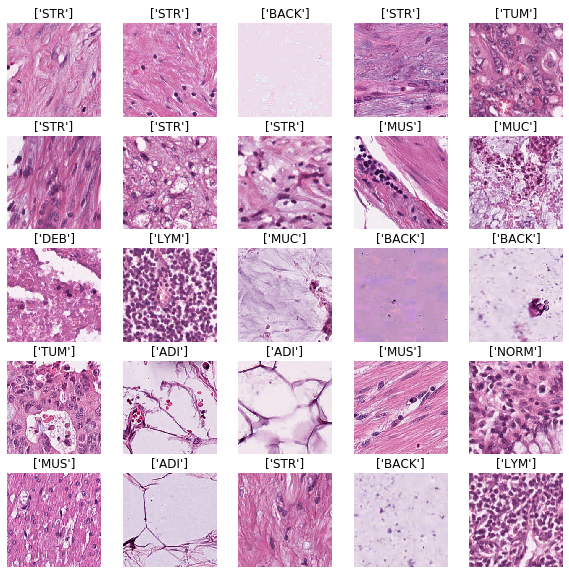

In [7]:
data_visualisation(train_generator)

We can observe 25 images of one batch (not the whole batch). You can observe that in each batch there are few examples for each class.

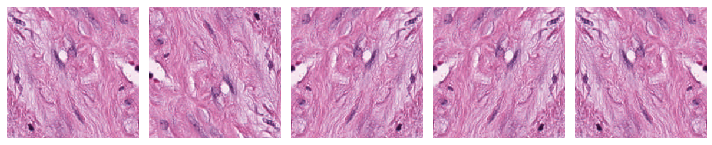

In [8]:
data_augment_visualisation(train_generator)

Above we observe the same image after data augmentation, i.e. it is sometimes horizontally and/or vertically flipped.

## Model source
Here we are going to download the model pretrained on ImageNet directly with Tensorflow.

You can find different models (e.g. Alexnet, VGG19, Densenet, Resnet50, etc) that can be downloaded and used without to have to build the architecture yourself here: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In our case we will work with **VGG19** model, for more information about this architecture: Simonyan, K., & Zisserman, A. (2014). Very deep convolutional networks for large-scale image recognition. https://arxiv.org/pdf/1409.1556.pdf.

*Note: to learn more about the different architectures: https://towardsdatascience.com/neural-network-architectures-156e5bad51ba*

Parameters of the model:
- *include_top*: whether to keep the last fully connected layer or not. As we have only 9 classes (compared to 1000 classes in ImageNet), we do not want this layer.
- *weights*: imagenet, to initialize the network with imagenet weights
- *input_shape*: the shape of the input image, each patch is 224x224 pixels with 3 channels (RGB)

In [11]:
from tensorflow.keras.applications.vgg19 import VGG19
source_model = VGG19(include_top=False, weights='imagenet', input_shape=(224,224,3))

Model architechtures with the number of parameter in each layer (without the fc layers)

In [12]:
source_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Let's also compare our model with a model trained from scratch.

In [61]:
random_init_model = VGG19(include_top=False, weights=None, input_shape=(224,224,3))

## Design the last layers of the network for the histology dataset
We need to import different layers:
- Flatten: it flattens the input (i.e.: from shape 7x7x512 to shape 25'088
- Dense: densely connected layer - every input neuron is connected to every output neuron
- Dropout: layer used to prevent overfitting, it randomly sets some neuron to 0 with a probability of your choice (in our case we will set it to 0.5)

We also need a regularizers:
- l2: regularization penalty

And finally we will create our model of interest with our inputs and outputs.

In [13]:
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model

x = source_model.output

x = Flatten(name='flatten')(x)
x = Dense(4096,activation='relu',
          kernel_regularizer=l2(1e-4),
          name='fc6')(x)
x = Dropout(0.5, name='drop6')(x)
x = Dense(4096,activation='relu',
          kernel_regularizer=l2(1e-4),
          name='fc7')(x)
x = Dropout(0.5, name='drop7')(x)

preds = Dense(9, activation='softmax', name='prob')(x)
# Final model: 
target_model = Model(inputs=source_model.input, outputs=preds)

In [14]:
# print final model
target_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

If you don't want to train the entire model and freeze some of the weights of ImageNets you can do it as follow:

In this example we will compare one model where the whole network is retrained and one model where we freeze the first 10 layers.

When you freeze part of the network, you can see that you have less parameters to train (Non-trainable params > 0). This means that it will take less time to train. The hypothesis behind freezing part of the network is that the lowest layers are detecting low level features (edge detection, curve detection, dots detection, etc.) which are generalizable across different tasks.

In [15]:
target_model_frozen = tf.keras.models.clone_model(target_model)

# To freeze part of the model
for layer in target_model_frozen.layers[:10]:
    layer.trainable = False

for layer in target_model_frozen.layers[10:]:
    layer.trainable = True

In [16]:
target_model_frozen.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [63]:
# for the model trained from scratch
x = random_init_model.output

x = Flatten(name='flatten')(x)
x = Dense(4096,activation='relu',
          kernel_regularizer=l2(1e-4),
          name='fc6')(x)
x = Dropout(0.5, name='drop6')(x)
x = Dense(4096,activation='relu',
          kernel_regularizer=l2(1e-4),
          name='fc7')(x)
x = Dropout(0.5, name='drop7')(x)

preds = Dense(9, activation='softmax', name='prob')(x)
# Final model: 
random_init_target_model = Model(inputs=random_init_model.input, outputs=preds)

## Train the model

We need to define an optimizer in order to reduce the loss while training our model:

Here we will use Stochastic Gradient Descent with Momentum (SGDM) with a momentum of 0.9 (standard) (more information about SGD: https://towardsdatascience.com/stochastic-gradient-descent-clearly-explained-53d239905d31). 

We also need to define the learning rate which we will set here to 1e-4. The learning rate is a hyperparameter that you can play with and observe how the learning curve is evolving.

Then we need to compile our model (i.e. configure it) with: an optimizer (*SGDM*), a loss function (here it will be *categorical_crossentropy* as we have more than 2 classes) and we can define a list of metrics that we want to evaluate (in our case we will have the *accuracy*).

Then we need to define the number of epoch: how many times the network will pass through the entire dataset. As we use transfer learning, we can set it relatively small: we will train for 8 epochs. This parameter should be adapted depending on your learning curve. Also another good strategy is to set a maximum number of epochs and add an early stopping when a specific condition is reached (more information there: https://medium.com/zero-equals-false/early-stopping-to-avoid-overfitting-in-neural-network-keras-b68c96ed05d9)

In [17]:
from tensorflow.keras.optimizers import SGD

opti = SGD(lr=1e-4, momentum=0.9)

target_model.compile(optimizer=opti,
                     loss='categorical_crossentropy', 
                     metrics=['accuracy'])

target_model_frozen.compile(optimizer=opti,
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])

random_init_target_model.compile(optimizer=opti,
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])

epochs = 8

We can print how many step we need for the training.

In [18]:
print('step size:', train_generator.n//train_generator.batch_size)

step size: 3125


Now lets train the network. 
In order to train the model, we can use the 'fit' function with the following parameters:
- *x*: training generator
- *steps_per_epoch*: number of steps per epoch, wich is the number of samples divided by the batch size.
- *epochs*: number of epochs

In [19]:
import time

start_time = time.time()

history = target_model.fit(x=train_generator,
                           steps_per_epoch=train_generator.samples // train_generator.batch_size, 
                           epochs=epochs)

time_elapsed = time.time() - start_time
print("Training complete in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))

Train for 3125 steps
Epoch 1/8
3125/3125 [==============================] - 1714s 549ms/step - loss: 1.4347 - accuracy: 0.8905
Epoch 2/8
3125/3125 [==============================] - 1693s 542ms/step - loss: 1.2232 - accuracy: 0.9653
Epoch 3/8
3125/3125 [==============================] - 1715s 549ms/step - loss: 1.1875 - accuracy: 0.9763
Epoch 4/8
3125/3125 [==============================] - 1705s 545ms/step - loss: 1.1726 - accuracy: 0.9802
Epoch 5/8
3125/3125 [==============================] - 1698s 544ms/step - loss: 1.1615 - accuracy: 0.9832
Epoch 6/8
3125/3125 [==============================] - 1686s 539ms/step - loss: 1.1538 - accuracy: 0.9848
Epoch 7/8
3125/3125 [==============================] - 1686s 540ms/step - loss: 1.1467 - accuracy: 0.9866
Epoch 8/8
3125/3125 [==============================] - 1691s 541ms/step - loss: 1.1422 - accuracy: 0.9877
Training complete in 229m 0s


Now let's train the model that has 10 frozen layers and see what are the differences.

In [20]:
import time

start_time = time.time()

history_frozen = target_model_frozen.fit(x=train_generator,
                                         steps_per_epoch=train_generator.samples // train_generator.batch_size, 
                                         epochs=epochs)

time_elapsed = time.time() - start_time
print("Training complete in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))

Train for 3125 steps
Epoch 1/8
3125/3125 [==============================] - 1071s 343ms/step - loss: 3.3041 - accuracy: 0.1427
Epoch 2/8
3125/3125 [==============================] - 1089s 349ms/step - loss: 3.2971 - accuracy: 0.1432
Epoch 3/8
3125/3125 [==============================] - 1073s 343ms/step - loss: 3.2938 - accuracy: 0.1432
Epoch 4/8
3125/3125 [==============================] - 1069s 342ms/step - loss: 3.2877 - accuracy: 0.1441
Epoch 5/8
3125/3125 [==============================] - 1048s 335ms/step - loss: 3.2386 - accuracy: 0.1914
Epoch 6/8
3125/3125 [==============================] - 1089s 349ms/step - loss: 3.0849 - accuracy: 0.2412
Epoch 7/8
3125/3125 [==============================] - 1078s 345ms/step - loss: 2.9783 - accuracy: 0.2925
Epoch 8/8
3125/3125 [==============================] - 1082s 346ms/step - loss: 2.7263 - accuracy: 0.3480
Training complete in 145m 46s


In [65]:
import time

start_time = time.time()

history_random = random_init_target_model.fit(x=train_generator,
                                            steps_per_epoch=train_generator.samples // train_generator.batch_size, 
                                              epochs=epochs)

time_elapsed = time.time() - start_time
print("Training complete in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))

Train for 3125 steps
Epoch 1/8
3125/3125 [==============================] - 1708s 547ms/step - loss: 3.3037 - accuracy: 0.1429
Epoch 2/8
3125/3125 [==============================] - 1683s 539ms/step - loss: 3.2965 - accuracy: 0.1432
Epoch 3/8
3125/3125 [==============================] - 1701s 544ms/step - loss: 3.2915 - accuracy: 0.1433
Epoch 4/8
3125/3125 [==============================] - 1715s 549ms/step - loss: 3.0220 - accuracy: 0.2333
Epoch 5/8
3125/3125 [==============================] - 1701s 544ms/step - loss: 2.4707 - accuracy: 0.4522
Epoch 6/8
3125/3125 [==============================] - 1682s 538ms/step - loss: 2.3142 - accuracy: 0.5178
Epoch 7/8
3125/3125 [==============================] - 1705s 546ms/step - loss: 2.1781 - accuracy: 0.5662
Epoch 8/8
3125/3125 [==============================] - 1697s 543ms/step - loss: 2.0430 - accuracy: 0.6219
Training complete in 229m 4s


**Time differences**

Using 1 GPU:
- "normal" model: 229 min 0 sec
- "10 frozen layers" model: 145 min 46 sec
- "random" model: 229 min 4 sec

=> Freezing 10 layers speed up the training to around 1.5 times

**Accuracies**
- "normal" model: 0.9838
- "10 frozen layers" model: 0.3480
- "random" model: 0.6219

=> The train accuracy is very high when retraining all layers pretrained on ImageNet, on the other hand freezing part of the network decrease the performance. We would need to train longer to maybe reach the same accuracy.

=> Training from random weights lead to a better accuracy than freezing 10 layers but we would also need to train for longer.

=> Let's see how is the test accuracy on unseen data

## Let's visualize our training history
The history of the training was saved in history and contains the accuracies as well as the losses at each epoch.
We will plot the accuracies/losses in function of the epoch.

In [21]:
import matplotlib.pyplot as plt

def history_plot(history
                ) -> None:
    """
    Plot the history of the accuracies and losses at each epoch
    
    history: history of the training (this is the output of the function 'fit')
    """
    epochs_range = range(len(history.history['loss']))
    fig = plt.figure(figsize=(8, 8))
    
    # plot of accuracy
    ax = fig.add_subplot(1, 2, 1)
    acc = history.history['accuracy']
    ax.plot(epochs_range, acc)
    
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    
    # plot of loss
    ax = fig.add_subplot(1, 2, 2)
    loss = history.history['loss']
    ax.plot(epochs_range, loss)
    
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    
    plt.show()
    plt.clf()
    plt.cla()
    plt.close()

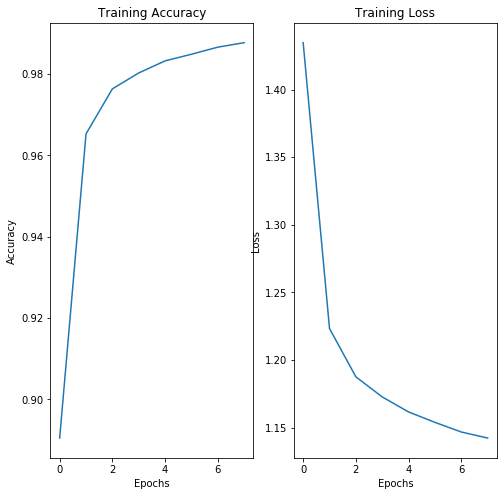

In [22]:
history_plot(history)

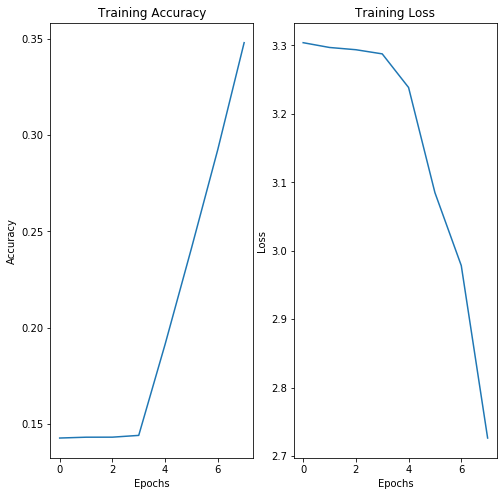

In [23]:
history_plot(history_frozen)

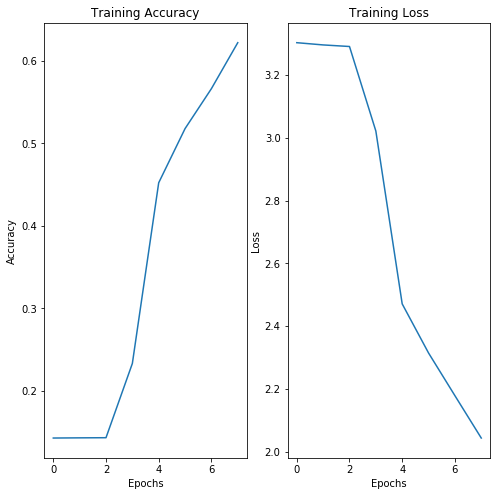

In [66]:
history_plot(history_random)

**Normal Model**

We can see that the training accuracy increase very rapidely and reach an accuracy of around 0.98. We also see that we are starting to reach a plateau and that training longer will not further improve the performance but might just overfit. On the training loss, we can see as expected that the loss is decreasing, meaning the model continues to learn.

**10 frozen layers Model**

When freezing 10 layers, we can see that the network takes more time to learn good representations of the data. We don't reach the plateau and would need to train much longer to reach a similar performance as when retraining all the layers. Another solution would be to modify the learning rate and for example have an adaptative learning rate (more information there: https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1).

**Random Init Model**

As for the model with 10 frozen layers, we didn't reach the plateau yet and would need to follow a similar strategy to reach a performance as high as the model pretrained on ImageNet with 0 frozen layers.

## Save model
We will save the model in case we want to use it for later. Like that we do not need to retrain it all the time entirely.
We might want to use it later, to train it for longer, to evaluate it, etc.

In [24]:
if not os.path.exists("Model"):
        os.makedirs("Model")

target_model.save('Model/target_model_v1.h5')
target_model_frozen.save('Model/target_model_frozen_v1.h5')
random_init_target_model.save('Model/target_model_random_v1.h5')

## Loading model
If you want to load a model you can use the load_model function from tensorflow and pass in the model path you want to load.

In [ ]:
path_model_saved = 'Model/target_model_v1.h5'
path_model_frozen_saved = 'Model/target_model_frozen_v1.h5'
path_model_random_saved = 'Model/target_model_random_v1.h5'

target_model = tf.keras.models.load_model(path_model_saved)
target_model_frozen = tf.keras.models.load_model(path_model_frozen_saved)
random_init_target_model = tf.keras.models.load_model(path_model_random_saved)

## Evaluate model
Now, let's evaluate our model on the test set which consist of 7'180 patches.
In order to evaluate the model, we can use the 'evaluate' function on the model with the following parameters:
- *x*: testing generator
- *steps*: number of steps, which is the number of samples divided by the batch size.

In [25]:
eva = target_model.evaluate(x = test_generator,
                            steps = test_generator.samples // test_generator.batch_size)

7180/7180 [==============================] - 152s 21ms/step - loss: 1.2963 - accuracy: 0.9497


In [50]:
eva_frozen = target_model_frozen.evaluate(x = test_generator,
                                          steps = test_generator.samples // test_generator.batch_size)

7180/7180 [==============================] - 157s 22ms/step - loss: 2.7022 - accuracy: 0.4302


In [68]:
eva_random = random_init_target_model.evaluate(x = test_generator,
                                               steps = test_generator.samples // test_generator.batch_size)

7180/7180 [==============================] - 147s 20ms/step - loss: 1.8469 - accuracy: 0.7253


**Normal Model**

We obtain an accuracy on the test set of 0.9497 which is really high.
It means that our model generalized well to an unseen dataset.

**10 frozen layers Model**

On the other hand, given our model perform not well on the training set we also get a poor performance on the test set (0.4302).

**Random Init Model**

We have a test accuracy of 0.7253. As expected, we get a better testing accuracy on the model randomly initialized than on the 10 frozen layers' one.

## Further analysis of the test performance

When working with medical data, it is a good practice to not only look at the accuracy, especially when the classes are really unbalanced.

In this tutorial we will look at two other performance metrics:

**Confusion matrix**:

Table that shows the performance of the model with the following information, True positive, True negative, False positive and False negative. More information: https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62


**AUC-ROC Curve**: 

AUC=Area Under the Curve, metric between 0 and 1. AUC=1 is a perfect model, it means that the model can perfectly distinguish between the classes. More information: https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5

Note: for the following analysis you need the following dependecies:
- pandas: https://pandas.pydata.org/pandas-docs/stable/getting_started/install.html
- scikit-learn: https://scikit-learn.org/stable/install.html
- seaborn: https://seaborn.pydata.org/installing.html

In [72]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
from typing import List
import numpy as np
import pandas.util.testing as tm

def plot_confusion_mat(y_true: np.ndarray, 
                       y_pred: np.ndarray, 
                       classes: List[str] = ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM'], 
                       title: str = "normal"
                      ) -> None:
    """
    Plot the confusion matrix using confusion_matrix function from scikit-learn
    
    y_true: true labels, number between 0 to (number of classes-1)
    y_pred: predicted labels, number between 0 to (number of classes-1)
    classes: list of the name of all the classes
    title: name of the experiment
    """
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm,
                         index=[i for i in classes],
                         columns=[i for i in classes])
    plt.figure(figsize=(10, 7))
    sn.heatmap(df_cm, annot=True, vmin=0, vmax=400, fmt=".0f", annot_kws={'size': 13}, square=True)
    plt.title("Confusion matrix: "+title)
    plt.show()
    plt.clf()
    plt.cla()
    plt.close()

In [56]:
from sklearn.metrics import classification_report
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np

def plot_AUC_ROC(y_true: np.ndarray, 
                 predictions: np.ndarray, 
                 classes: List[str] = ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM'], 
                 title: str = "normal"
                ) -> None:
    """
    Plot the AUC-ROC Curve for multiple-classes
    
    y_true: true labels, number between 0 to (number of classes-1)
    predictions: prediction probability for all classes
    classes: list of the name of all the classes
    title: name of the experiment
    """
    num_classes = len(classes)
    y_true = label_binarize(y_true, classes=list(range(num_classes)))
    for c in range(len(classes)):
        auc_roc = roc_auc_score(y_true[:, c], predictions[:, c])
        label = classes[c] + " AUC: %.3f " % auc_roc
        a, b, _ = roc_curve(y_true[:, c], predictions[:, c])
        plt.figure(1, figsize=(7, 7))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(a, b, label=label)
        plt.xlabel("False positive rate")
        plt.ylabel("True positive rate")
        plt.legend(loc="lower right")
    plt.title("AUC-ROC Curve: "+title)
    plt.show()
    plt.clf()
    plt.cla()
    plt.close()

In order to do these analysis we need the following:
- y_true: the true labels for each test image
- predictions: the prediction probability of each image for each class
- y_pred: the label predicted, which is the maximum of the prediction for that image

In [29]:
classes = ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']

y_true = test_generator.classes

In [30]:
predictions = target_model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)

In [31]:
predictions_frozen = target_model_frozen.predict(test_generator)
y_pred_frozen = np.argmax(predictions_frozen, axis=1)

In [69]:
predictions_random = random_init_target_model.predict(test_generator)
y_pred_random = np.argmax(predictions_random, axis=1)

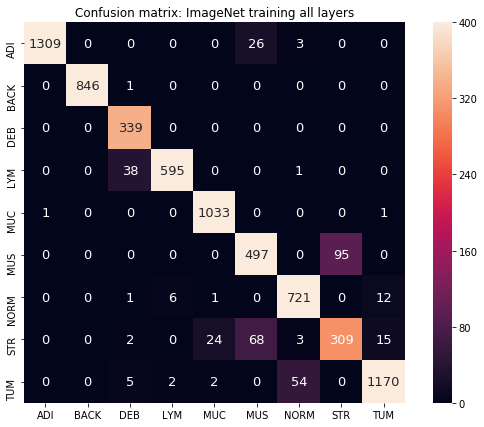

In [60]:
plot_confusion_mat(y_true, y_pred, classes, "ImageNet training all layers")

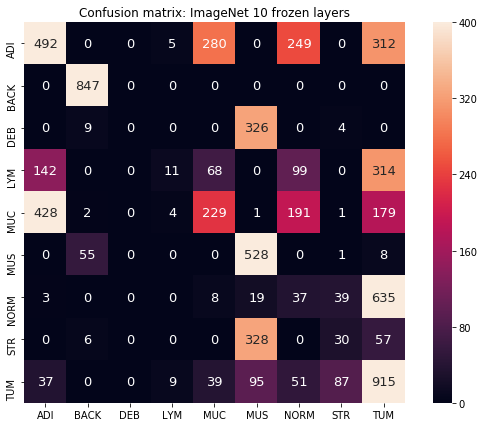

In [59]:
plot_confusion_mat(y_true, y_pred_frozen, classes, "ImageNet 10 frozen layers")

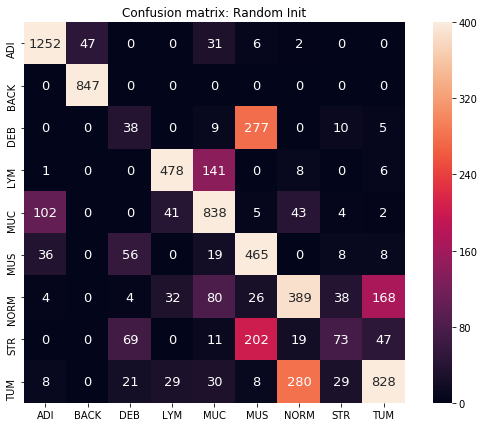

In [70]:
plot_confusion_mat(y_true, y_pred_random, classes, "Random Init")

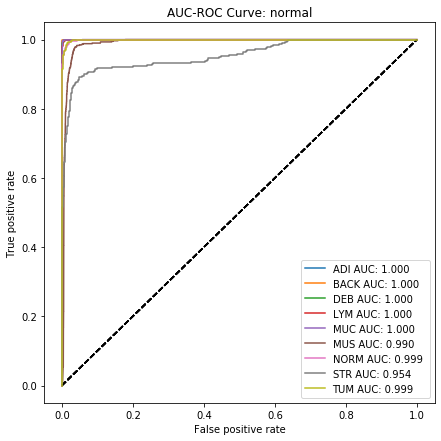

In [57]:
plot_AUC_ROC(y_true, predictions, classes, "normal")

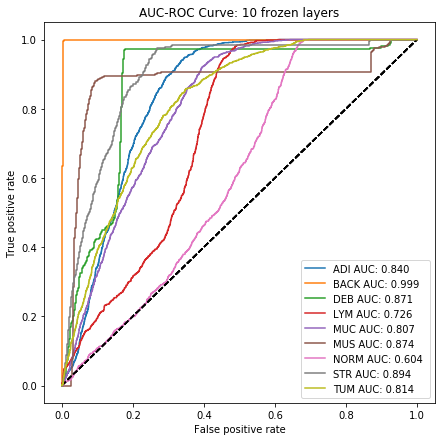

In [45]:
plot_AUC_ROC(y_true, predictions_frozen, classes, "10 frozen layers")

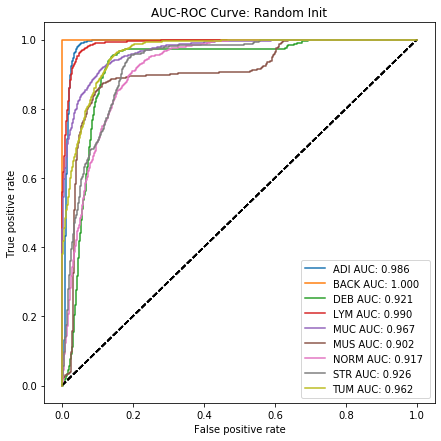

In [71]:
plot_AUC_ROC(y_true, predictions_random, classes, "Random Init")

## Evaluation of the result

Looking at the accuracy, the confusion matrix and the AUC-ROC curve, we can conclude the following:
- most misclassification are made between the two classes MUS and STR (as a reminder, MUS = Smooth Muscle, STR = Cancer-Associated Strom)
- Overall using ImageNet pretrained weights and retraining all layers gives a very good performance on an unseen external test sets. We can also observe that it really improves the speed of training compared to when training from scratch.
- We can forget about our "10 frozen layers" as it does not give any good results. One idea could be to freeze less layers. As an exercise you could try to freeze only 5 layers, how is the result now?
- Random initialization lead to relatively good results but it would need more epochs to reach similar test accuracies as the best fine tuned model. It is interesting to notice that most errors here are made between NORM-TUM and DEB-MUS which is different than MUS-STR.

## Conclusion

In this tutorial we learnt how to do transfer learning from ImageNet to histology dataset using Tensorflow. We did not try to get the best accuracy but just an idea of the structure and the first analysis that can be done to evaluate the model.

We could observe that using ImageNet weights as the initialization of the weights really increase the training curve as well as the performance.

A question we could ask ourself is whether the features learned are meaningful and whether the ImageNet models are not overparameterized for our taks. ImageNet mainly contains natural images which, as you can imagine (and see), is very different from histological images. I leave you up here for some reflexions.

We reached the end of the tutorial. I hope you enjoyed it and that you learned something. Thank you for followin it! :)

If you want to go a bit further, you can find below two optional analysis to go deeper in the results.

## [Optional] Observation of some mislabelled predictions
We can observe some test images that were mislabeled to see whether as a human we would also do the mistake or not.

In [73]:
from tensorflow.keras.preprocessing import image
import numpy

def plot_error_prediction(predictions: numpy.ndarray,
                          test_generator
                         ) -> None:
    """
    Plot some examples of images wrongly predicted
    
    predictions: prediction probability for all classes
    test_generator: test data generator
    """
    y_true = test_generator.classes
    predicted = np.argmax(predictions, axis=1)
    errors = np.where(predicted != y_true)[0]
    print("No of errors = {}/{}".format(len(errors), test_generator.samples))

    fnames = test_generator.filenames

    # Get the label to class mapping from the generator
    label2index = test_generator.class_indices

    # Getting the mapping from class index to class label
    idx2label = dict((v, k) for k, v in label2index.items())
    
    # plot errors
    for im in range(0,len(errors)):
        pred_class = np.argmax(predictions[errors[im]])
        pred_label = idx2label[pred_class]

        title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
            fnames[errors[im]].split('/')[0],
            pred_label,
            predictions[errors[im]][pred_class])
        
        original = image.load_img(os.path.join(PATH_TO_DATA_TEST,fnames[errors[im]]))
        plt.figure(figsize=[7, 7])
        plt.axis('off')
        plt.title(title)
        plt.imshow(original)
        plt.show()
        plt.clf()
        plt.cla()
        plt.close()

In [ ]:
plot_error_prediction(predictions, test_generator)

## [Optional] Confidence matrices
We have seen that the model does quite some mistakes, now the question we can ask ourself is whether the model was very confident of its decision or not.

In order to do that we plot the "confidence matrices", it is similar to a confusion matrix, but we are instead measuring the average probability of each decision.

In [75]:
import numpy as np
import warnings

def plot_confidence_matrix(y_true: np.ndarray, 
                           y_pred: np.ndarray, 
                           predictions, 
                           classes = ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']
                           ) -> None:
    """
    Plot the confidence matrix
    
    y_true: true labels, number between 0 to (number of classes-1)
    y_pred: predicted labels, number between 0 to (number of classes-1)
    predictions: prediction probability for all classes
    classes: list of name of the classes
    """
    proba_av = np.empty((len(classes), len(classes), len(predictions)))
    proba_av[:] = np.nan
    # for each test example
    for i in range(len(predictions)):
        # take the max probablily
        proba_av[y_true[i], y_pred[i], i] = max(predictions[i])
    # supress warning when mean of nan.
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        # calculate average of the confidence for each possible case in the matrix
        proba_av = np.nanmean(proba_av, 2)
    # plot
    df_cm = pd.DataFrame(proba_av,
                         index=[i for i in classes],
                         columns=[i for i in classes])
    plt.figure(figsize=(10, 7))
    sn.heatmap(df_cm,
               annot=True,
               vmin=0,
               vmax=1,
               fmt=".2f",
               annot_kws={'size': 13},
               square=True)
    plt.title("confidence matrix")
    plt.show()
    plt.clf()
    plt.cla()
    plt.close()

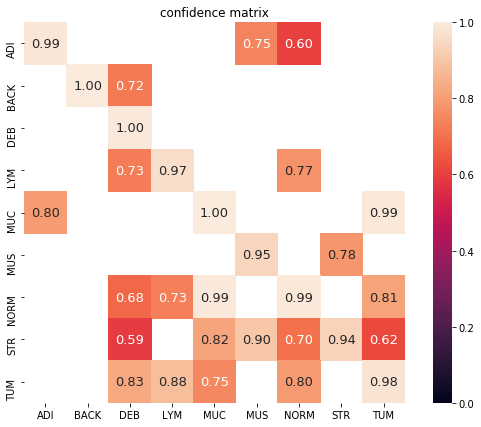

In [76]:
plot_confidence_matrix(y_true, y_pred, predictions, classes)

What you would expect in such a plot is a value as close as possible to 1 in the diagonal (i.e. correct prediction) and as small as possible everywhere else (i.e. false prediction). The smallest value possible is 1/9 = 0.11. A value clone to 1 means that the model is confident about it's prediction, on the other hand, a value close to 0.11 means that the network is not confident of it's decision and it might be more like a 'random' choice.


We can observe here that the model tend to be overconfident even when it does a wrong prediction. When working with deep learning we should keep in mind that problem and work on a solution to have a more calibrated model.